## 1. Load basic modules 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


# 2.Load CSV 

In [2]:
data = pd.read_csv("../documents/data_both_scores.csv")
data.head(20)

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,AgeinYr,bmi,fram,esc
0,f,110.0,80.0,normal,normal,no,no,yes,0,50,21.97,15,2
1,m,140.0,90.0,high,normal,no,no,yes,1,55,34.93,15,10
2,m,130.0,70.0,high,normal,no,no,no,1,51,23.51,12,6
3,f,150.0,100.0,normal,normal,no,no,yes,1,48,28.71,17,2
4,m,100.0,60.0,normal,normal,no,no,no,0,47,23.01,17,2
5,m,120.0,80.0,bordering,prediabetes,no,no,no,0,60,29.38,12,9
6,m,130.0,80.0,high,normal,no,no,yes,0,60,37.73,16,10
7,f,130.0,90.0,high,diabetes,no,no,yes,1,61,29.98,16,6
8,m,110.0,70.0,normal,normal,no,no,yes,0,48,28.44,11,3
9,m,110.0,60.0,normal,normal,no,no,no,0,54,25.28,12,3


In [3]:
data.shape

(67359, 13)

In [4]:
model = sm.GLM.from_formula("cardio ~ gender + AgeinYr + cholesterol + gluc + smoke + alco + active + bmi + fram + esc", family = sm.families.Binomial(), data=data)

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 cardio   No. Observations:                67359
Model:                            GLM   Df Residuals:                    67346
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39953.
Date:                Thu, 14 Jul 2022   Deviance:                       79906.
Time:                        12:54:56   Pearson chi2:                 7.27e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.5938      0.122     -4.876      0.000      -0.832      -0.355
gender[T.m]              -0.9415      0.028    -33.049      0.000      -0.997      -0.886
cholesterol[T.high]       0.1972      0.043      4.621      0.000       0.114       0.281
cholesterol[T.normal]    -0.3759      0.030    -12.660      0.000      -0.434      -0.318
gluc[T.normal]            0.4060      0.039     10.306      0.000       0.329       0.483
gluc[T.prediabetes]       0.4309      0.051      8.517      0.000       0.332       0.530
smoke[T.yes]             -1.8966      0.043    -44.211      0.000      -1.981      -1.813
alco[T.yes]              -0.1553      0.040     -3.836      0.000      -0.235      -0.076
active[T.yes]            -0.1763      0.021     -8.237      0.000      -0.218      -0.134
AgeinYr                  -0.0651      0.002    -28.893      0.000      -0.069      -0.061
bmi                       0.0446      0.002     24.501      0.000       0.041       0.048
fram                      0.0997      0.004     27.323      0.000       0.093       0.107
esc                       0.4433      0.008     56.920      0.000       0.428       0.459
=========================================================================================
"""

**The p-values for most of the variables are smaller than 0.05, so we keep all the features**

In [5]:
data[["cardio", "gender", "AgeinYr", "cholesterol", "gluc", "smoke", "alco", "active", "bmi", "fram", "esc"]].corr()


,cardio,AgeinYr,bmi,fram,esc
cardio,1.000000,0.235421,0.190022,0.182982,0.329704
AgeinYr,0.235421,1.000000,0.096048,0.398127,0.681668
bmi,0.190022,0.096048,1.000000,0.066508,0.233437
fram,0.182982,0.398127,0.066508,1.000000,0.244956
esc,0.329704,0.681668,0.233437,0.244956,1.000000


# 3.Transform the Categorical Variables: Creating Dummy Variables

In [6]:
categoricals = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]

enc = OneHotEncoder(drop = "first")
X = data[categoricals]
enc.fit(X)
enc.categories_

[array(['f', 'm'], dtype=object),
 array(['bordering', 'high', 'normal'], dtype=object),
 array(['diabetes', 'normal', 'prediabetes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object)]

In [7]:
dummies = enc.transform(X).toarray()
dummies
dummies_df = pd.DataFrame(dummies)
dummies_df

col_names = [categoricals[i] + '_' + enc.categories_[i] for i in range(len(categoricals))] 
                                                                 #range(len(categoricals)) = 0 a 6
col_names_drop_first = [sublist[i] for sublist in col_names for i in range(len(sublist)) if i != 0]
dummies_df.columns = col_names_drop_first
variables_numericas = ["AgeinYr", "ap_hi", "ap_lo", "bmi", "fram", "esc"]
data_numerica = data[variables_numericas]
data_final = pd.concat([dummies_df, data_numerica,data["cardio"]], axis = 1)
data_final.head()

,gender_m,cholesterol_high,cholesterol_normal,gluc_normal,gluc_prediabetes,smoke_yes,alco_yes,active_yes,AgeinYr,ap_hi,ap_lo,bmi,fram,esc,cardio
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,50,110.0,80.0,21.97,15,2,0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,55,140.0,90.0,34.93,15,10,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,51,130.0,70.0,23.51,12,6,1
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,48,150.0,100.0,28.71,17,2,1
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,47,100.0,60.0,23.01,17,2,0


## 4.Logistic Regression Model Fitting


In [8]:
X = data_final.drop("cardio", axis = 1)
y = data_final["cardio"]

In [9]:
logistic_regression = LogisticRegression()


In [10]:
# We separate the training data from the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

In [11]:
# We standardize the data to obtain a correct regularization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

### Predicting the test set results and calculating the accuracy


In [12]:
#Model Fitting
logistic_regression.fit(X_train_std, y_train)


y_train_pred = logistic_regression.predict(X_train_std)
y_test_pred = logistic_regression.predict(X_test_std)

In [13]:
accuracy_score(y_test, y_test_pred)

0.7296912114014252

Text(33.0, 0.5, 'Reales')

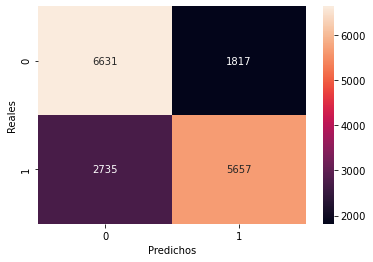

In [14]:
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [15]:
logistic_regression.predict_proba(X_train_std[y_train==0])[:,1]

array([0.37758282, 0.18375924, 0.48460283, ..., 0.29348456, 0.44912504,
       0.38236013])

In [16]:
logistic_regression.predict_proba(X_train_std[y_train==1])[:,1]

array([0.6226604 , 0.72642756, 0.43791933, ..., 0.3461376 , 0.58622018,
       0.99218597])

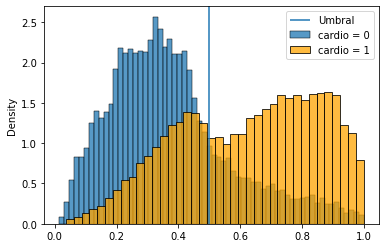

In [17]:
# Histograma de probabilidades
sns.histplot(data = logistic_regression.predict_proba(X_train_std[y_train==0])[:,1], stat = 'density')
sns.histplot(data = logistic_regression.predict_proba(X_train_std[y_train==1])[:,1], stat = 'density', color = 'orange')
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'cardio = 0', 'cardio = 1'])

In [18]:
print("Accuracy: ", accuracy_score(y_test, y_test_pred).round(2))
print("F1 Score: ", f1_score(y_test, y_test_pred).round(2))
print('precision_score: ', precision_score(y_test, y_test_pred).round(2))
print('recall_score: ', recall_score(y_test, y_test_pred).round(2))
print('MSE: ', mean_squared_error(y_test, y_test_pred).round(3))

Accuracy:  0.73
F1 Score:  0.71
precision_score:  0.76
recall_score:  0.67
MSE:  0.27


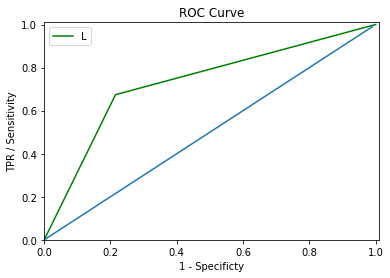

In [19]:
fpr_lr,tpr_lr,thr_lr = roc_curve(y_test, y_test_pred)

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_lr, tpr_lr, 'g')
plt.legend('LR')
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [20]:
print('AUC=', round(auc(fpr_lr, tpr_lr),2))

AUC= 0.73


In [21]:
#Dada la naturaleza del probelma, conviene utilizar una estrategia que impida clasificar como pacientes sanos a aquellos que están en riesgo.

umbral = 0.4
probs = logistic_regression.predict_proba(X_test)[:,1]
y_pred_umbral = probs > umbral

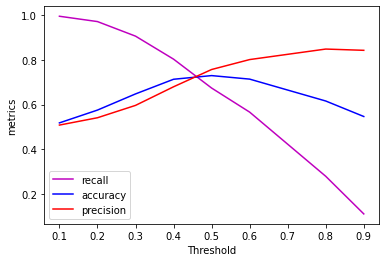

In [22]:
recalls = []
accuracy = []
precision = []

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]

probs_train = logistic_regression.predict_proba(X_train_std)[:,1]
probs_test = logistic_regression.predict_proba(X_test_std)[:,1]

for th in thresholds:
    y_pred_test_umbral = probs_test > th
    rec = recall_score(y_test, y_pred_test_umbral)
    acc = accuracy_score(y_test, y_pred_test_umbral)
    pres = precision_score(y_test, y_pred_test_umbral)
    
    
    recalls.append(rec)
    accuracy.append(acc)
    precision.append(pres)
    
 # plot the recalls values
plt.plot(thresholds, recalls, 'm')
plt.plot(thresholds, accuracy, 'b')
plt.plot(thresholds, precision, 'r')

plt.legend(['recall', 'accuracy', 'precision'])

plt.xlabel('Threshold')
plt.ylabel('metrics')
plt.show() 

In [23]:
umbral = 0.4
probs_train_04 = logistic_regression.predict_proba(X_train_std)[:,1]
probs_test_04 = logistic_regression.predict_proba(X_test_std)[:,1]

y_pred_train_umbral_04 = probs_train > umbral
y_pred_test_umbral_04 = probs_test > umbral

Text(33.0, 0.5, 'Reales')

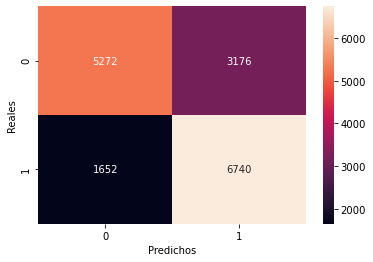

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred_test_umbral_04), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [25]:
print("Accuracy: ", accuracy_score(y_test, y_pred_test_umbral_04).round(2))
#print("F1 Score: ", f1_score(y_test, y_pred_test_umbral_04).round(2))
print('precision_score: ', precision_score(y_test, y_pred_test_umbral_04).round(2))
print('recall_score: ', recall_score(y_test, y_pred_test_umbral_04).round(2))
#print('MSE: ', mean_squared_error(y_test, y_pred_test_umbral_04).round(3))

Accuracy:  0.71
precision_score:  0.68
recall_score:  0.8
MSE:  0.287


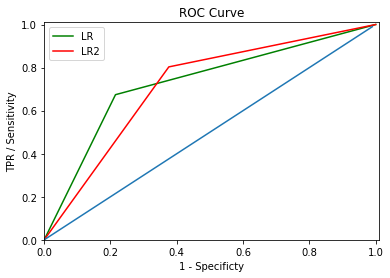

In [26]:
fpr_lr2,tpr_lr2,thr_lr2 = roc_curve(y_test, y_pred_test_umbral_04)

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_lr, tpr_lr, 'g')
plt.plot(fpr_lr2, tpr_lr2, 'r')

plt.legend(['LR', 'LR2'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [27]:
print('AUC umbral 0.5 = '  , round(auc(fpr_lr, tpr_lr),2))
print('AUC umbral 0.4 = ', round(auc(fpr_lr2, tpr_lr2),2))

AUC umbral 0.5 =  0.73
AUC umbral 0.4 =  0.71


In [30]:
mask = data['fram'] < 0 
data[mask]

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,AgeinYr,bmi,fram,esc
599,m,120.0,70.0,normal,normal,no,no,yes,0,39,24.09,-2,3
1213,m,120.0,80.0,normal,normal,no,no,yes,0,39,36.00,-4,2
1678,m,120.0,80.0,normal,normal,no,no,yes,0,39,21.26,-1,2
1878,m,110.0,70.0,normal,normal,no,no,no,1,39,29.41,-1,2
2167,m,110.0,80.0,normal,normal,no,no,yes,0,39,23.31,-2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64100,m,110.0,70.0,normal,normal,no,no,yes,0,39,22.58,-2,2
64787,m,110.0,70.0,normal,diabetes,no,no,no,0,39,26.93,-1,2
65706,m,120.0,80.0,normal,normal,no,no,yes,0,39,36.00,-1,2
65747,m,120.0,80.0,normal,normal,no,no,yes,0,39,21.37,-2,2
